In [2]:
import math
import numpy as np

import matplotlib.pyplot as plt
import sys

#### direvatives

In [3]:
def f(x):
    return x - 5*x**2

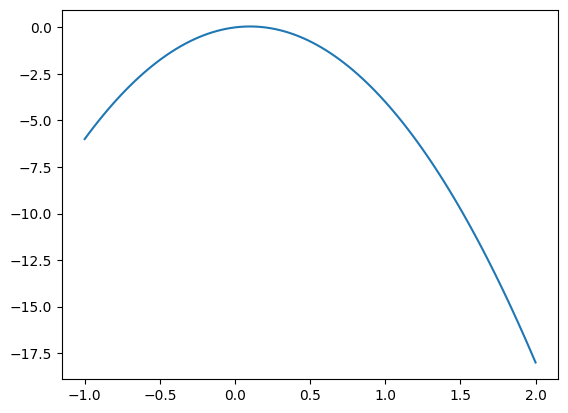

In [4]:
x = np.linspace(-1, 2, 100)
y = f(x)

plt.plot(x, y)
plt.show()

In [5]:
# numerical derivative, numerical approximation of the slope of the tangent line
h = 0.000001
x = 5
df = (f(x+h) - f(x))/(h)
print(df)

-49.000005006405445


In [6]:
a = 5
b = -4
c = 26
d = a*b + c

# dirivative of d with respect to a
d1 = a*b + c
a += h 
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope : ", (d2-d1)/h)    

d1 6
d2 5.999995999999999
slope :  -4.000000000559112


##### Data Structure 

In [32]:
class Value:

    def __init__(self, data, _children=(), _op='') -> None:
        self.value: int = data
        self.grad = .0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Value(data={self.value}, size={sys.getsizeof(self)}Bytes)"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to make a+1.0 work
        out = Value(self.value + other.value, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), "*")
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return other * self
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.value
        out = Value(math.exp(x), (self,))
        def _backward():
            self.grad += out.value * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**(-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.value**other, (self,))

        def _backward():
            self.grad += other * self.value**(other-1) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    
    def backward(self):
        # build the topological graph to order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

a = Value(32)
b = Value(2)
print(a, b)
print(a+b)
print(a*b)
d = a*b + a
print(d)

d.backward()

print(d.grad, a.grad, b.grad)

Value(data=32, size=56Bytes) Value(data=2, size=56Bytes)
Value(data=34, size=56Bytes)
Value(data=64, size=56Bytes)
Value(data=96, size=56Bytes)
1.0 3.0 32.0


In [8]:
print(d._prev, d._op)

{Value(data=64, size=56Bytes), Value(data=32, size=56Bytes)} +


In [9]:
# Bug, should be 2 instead of 1, in the function _backward of addition,
#  we are overriding the gradient value (1), when self is the same object as other
#  when we use a variable more then ones
#  we should accumulate those gradients, multivariate case of chain rule
s = a + a
s.backward()
print(s.grad, a.grad)
# Expected 2, got 1 for s.grad

1.0 5.0


In [10]:
# Bug fixed
a = Value(32)
s = a + a
s.backward()
print(s.grad, a.grad)

1.0 2.0


To run back propagation, we need to store all the nodes in a topological order, then run the function in reverse order.

In [11]:
a = Value(2.0)
b = Value(4.0)
print(a/b)
a-b

Value(data=0.5, size=56Bytes)


Value(data=-2.0, size=56Bytes)

### NN

In [12]:
class Neuron:
    def __init__(self, n) -> None:
        self.w = [Value(np.random.randn()) for _ in range(n)]
        self.b = Value(np.random.randn())

    def __call__(self, x):
        a = sum((wi+xi for wi, xi in zip(self.w, x)), self.b)
        return a.tanh()
    
    
x = [2.0, 3.0]
n = Neuron(2)
n(x) # python will call n.__call__(x)

Value(data=0.9974385829796502, size=56Bytes)

In [16]:
class Layer:
    def __init__(self, nin, nout) -> None:
        self.nin = nin
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def forward(self, x):
        return [neuron(x) for neuron in self.neurons]
    
    def __call__(self, x):
        return self.forward(x)[0] if self.nout == 1 else self.forward(x)
    
l = Layer(2, 3)
l(x)

[Value(data=0.9972352774618694, size=56Bytes),
 Value(data=0.9999998278924521, size=56Bytes),
 Value(data=0.9997210452221078, size=56Bytes)]

In [17]:
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
input = [2.0, 3.0]
mlp = MLP(2, [3, 4, 1]) 
mlp(input)

Value(data=0.9997614421095196, size=56Bytes)

In [23]:
# example
xs = [
    [2.0, 3.0, 1.0, 15.0],
    [1.0, 2.0, 3.0, 4.0],
    [3.0, 2.0, 1.0, 0.0]
]
target = [1.0, 0.0, 1.0]
pred = [mlp(xs[i]) for i in range(3)]
pred

[Value(data=0.9997614421095196, size=56Bytes),
 Value(data=0.999760374275818, size=56Bytes),
 Value(data=0.9997614421095196, size=56Bytes)]

let's define a loss to mesure the error of the model, we will use the mean squared error.

In [33]:
def mse(pred, target):
    return sum((p-t)**2 for p, t in zip(pred, target))

loss = mse(pred, target)
loss

Value(data=0.999520919791858, size=56Bytes)

In [34]:
loss.backward()

In [42]:
mlp.layers[1].neurons[0].w[1].grad

0.00017020607357355207